In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import random

### Genomic Imprinting Project:

Genomic imprinting is a process via which a subset of genes are marked with their parental origin and expressed in a monoallelic, parental-specific pattern. Imprinted genes are established through the use of DNA methylation and post-translational histone modifications, and escape the extensive reprogramming and erasures of epigenetic marks that occurs in the mammalian genome post-fertilization. Epigenetic marks on imprinted genes influence transcription, are heritable, and can be erased (new marks can be established at time of reproduction and gamete formation). They play important roles in mammalian development and reproduction, and largely code for factors regulating embryonic and neonatal growth, normal brain function, and energy homeostasis. The mechanism arose independently at least 3 times during the evolution of life, and multiple hypothesis attempt to explain as to why it evolved. (Barlow and Bartolomei 2014, Bartolomei and Ferguson-Smith 2011).

My project deals with genomic imprinting in an NK fitness landscape, and how imprinting affects offspring fitness & evolution. Like in a typical fitness landscape, we start by creating an NK table that will determine the fitness values of our genomes. In this project, we predetermined all of the genomes and associated fitness values that can exist in a population of certain genome size, to make the program more efficient. Our population consisted of organisms, and each organism possessed 5 "genome" strings: 1)genome born with, 2)base pairs that can & can't be methylated 3)actual methylation pattern 4)an alternate genome having differential expression (would result if all sites that can be methylated ARE methylated) 5)real genome organism ends up with post-fertilization, post-imprinting, post-methylation, post-etc. Organisms were able to propagate and have offspring that were not identical to them (because of mutations and genomic imprinting), and could pass on the most advantageous methylation pattern to their offspring. Graphs below demonstate mean and max fitness values across generations, with or without genomic imprinting. 

In [3]:
#creating a table of fitness values at each genome base pair (N), for any possible given genome combination (2**K), 
#given epistatic constraints (K)

def makeNKTable(N,K): #N=genome length(bp) #k is epistasis
    NKTable=list()
    for n in range(N):
        L=list() 
        for i in range(2**K): 
            L.append(round(random.uniform(0.0,1.0),2))
        NKTable.append(L)
    return NKTable

print makeNKTable(5,2)

[[0.13, 0.89, 0.64, 0.19], [0.59, 0.96, 0.13, 0.12], [0.27, 0.98, 0.98, 0.6], [0.53, 0.78, 0.45, 0.82], [0.35, 0.47, 0.72, 0.94]]


In [4]:
#predetermining all of the possible genomes that can exist given a certain genome size(N)

def allPossibleGenomes(N):
    allGenomes=list()
    for p in range(2**N):
        genome=list()
        for n in range(N):
            genome.append(((p>>n)&1))
        allGenomes.append(list(genome))
    return allGenomes 

G=allPossibleGenomes(5)
print G[7]

[1, 1, 1, 0, 0]


In [5]:
#Converting a genome (e.g.[1,1,0]) to its interger counterpart (e.g. 6)

def convertBinary(genome):
    sequence = [2 ** x for x in range(len(genome))]
    pattern=sorted(sequence, reverse=True)
    binary=list()
    for i in range(len(genome)):
        binary.append(pattern[i]*genome[i])
    score=sum(binary)
    return score
  
convertBinary(G[7])

28

In [6]:
#computing the fitness of a single genome using NK landscape

def computeFitness(genome,NKTable,N,K):
    fitness=1.0
    for n in range(N):
        c=1
        s=0
        for k in range(K):
            s=s+(genome[(n+k)%N]*c) #s is the row index  #n is the column index
            c=c*2       
        fitness=fitness*NKTable[n][s] #fitness *pick out of NK table
    return pow(fitness,1.0/float(N))

random.seed(0)
print computeFitness(G[7],makeNKTable(5,2),5,2)

0.400159497752


In [7]:
#creating different methylation patterns an organism can have, where only one bp is methylated (e.g. 0000 1000 0100 0010)

def methylPatterns(N):
    metPatterns=list()
    metPatterns.append([0]*N)
    for p in range(N):
        methyl=list()
        for n in range(N):
            methyl.append(((p==n)&1))
        metPatterns.append(list(methyl))
    return metPatterns 

M=methylPatterns(5)
print M

[[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]


In [8]:
#creating our Organism class, which contains a single organism and it's associated genomes
#capable of producing offspring different from itself, and passing on imprints (altered methylation patterns)

N=5
K=3
T=makeNKTable(N,K) 
G=allPossibleGenomes(N)
mutRate=0.02

notBinary=list()        #predetermined binary genomes-->converted to integers
allWs=list()            #fitnesses of predetermined genomes; global variable applicable; will NEVER USE global variables again   

#determining the fitness value for all the genomes that can exist given a certain genome size
for i in range(len(G)):
    C=convertBinary(G[i])
    F=computeFitness(G[i],T,N,K)
    notBinary.append(C)
    allWs.append(F)

M=methylPatterns(N)          #possible methylation patterns
realGenomes=list()           #will contain resulting genomes given those methylation patterns
   
class Organism():
    def __init__(self, ancestor,N,mutRate):
        self.genome=list()
        self.imprintPotential=list()
        self.methylation=list()
        self.alternateGenome=list()
        self.realGenome=list()
                
        if ancestor==None:
            for i in range(N):
                self.genome.append(random.randint(0,1))
                self.imprintPotential.append(random.randint(0,1))
                self.methylation.append(random.randint(0,1))
                self.alternateGenome.append(random.randint(0,1))
        else:
            for i in range(N):
                if random.uniform(0.0,1.0)<mutRate:
                    self.genome.append(1-ancestor.genome[i])
                else:    
                    self.genome.append(ancestor.genome[i])
                if random.uniform(0.0,1.0)<mutRate:
                    self.imprintPotential.append(1-ancestor.imprintPotential[i])
                else:    
                    self.imprintPotential.append(ancestor.imprintPotential[i])
                if random.uniform(0.0,1.0)<mutRate:
                    self.alternateGenome.append(1-ancestor.alternateGenome[i])
                else:    
                    self.alternateGenome.append(ancestor.alternateGenome[i])
                self.methylation.append(ancestor.methylation[i])
        
        for i in range(N):    #Organism's REAL genome
            if self.methylation[i]==self.imprintPotential[i]:
                self.realGenome.append(self.alternateGenome[i])
            else:
                self.realGenome.append(self.genome[i])
                
        self.fitness=allWs[G.index(self.realGenome)]  #Organism's FITNESS
    
    def computeMethylation(self):    
        #seeing which methylation pattern yields highest fitness for this organism
        for q in range(len(M)):
            temp=list()
            for i in range(N):
                if M[q][i]==self.imprintPotential[i]:
                    temp.append(self.alternateGenome[i])
                else:
                    temp.append(self.genome[i])
            realGenomes.append(temp)  #resulting genomes given those methylation patterns

        self.tempFit=list()           #fitness levels of the resulting genomes (e.g. realGenomes)
        for i in range(len(M)):
            self.tempFit.append(allWs[G.index(realGenomes[i])])
    
        self.methylation=M[self.tempFit.index(max(self.tempFit))] #NEW methylation pattern to be passed on to offspring
            
    def __str__(self):
        return str(self.genome)
        return str(self.realGenome)
        
O=Organism(None,N,0.0) 
O1=Organism(O,N,mutRate)
print O1.fitness

0.652856417443


In [9]:
#creating a population, which contains all of our Organisms and associated genomes

def makePopulation(N,popSize): 
    population=list()
    for p in range(popSize):
        population.append(Organism(None,N,0.0))
    return population

T=makePopulation(N,50)
print T[2].realGenome

[0, 0, 1, 1, 1]


ValueError: [0, 1, 1, 0, 0, 1, 0, 0] is not in list

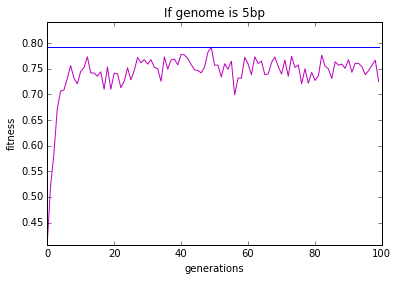

In [13]:
#Putting functions together to evolve my Organisms and their offspring, which are subjected to mutations and genomic imprinting

random.seed(0)
DifferentNs=[2,5,8,11,14,16]              #experiment 1:increase N
for N in DifferentNs:
    popSize=40
    P=makePopulation(N,popSize) 
    generations=100

    meanW=list() 
    maxW=list()

    for generation in range(generations):     
        W=list()                            #will contain the fitnesses of all of our Organisms  

        for j in range(len(P)):             
            W.append(P[j].fitness)

    #next generation of organisms are offspring of the previous generation's fittest individuals (subjected to imprinting and mutations)
        nextGeneration=list()
        while len(nextGeneration)<len(P):
            who=random.randint(0,popSize-1)
            who2=random.randint(0,popSize-1)
            if W[who]>W[who2]:
                O=Organism(P[who],N,mutRate)
            else:
                O=Organism(P[who2],N,mutRate)
            O.computeMethylation()
            nextGeneration.append(O)

        P=list(nextGeneration)
        meanW.append(mean(W))
        highestFitness=max(W)
        maxW.append(highestFitness)

    figure()
    title("If genome is {0}bp".format(N))
    plot(meanW,'m')
    plot(maxW,'b')
    xlabel("generations")
    ylabel("fitness")
    ylim(min(meanW),highestFitness+0.05)

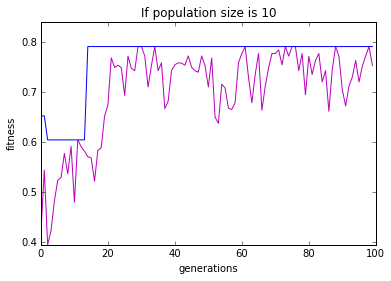

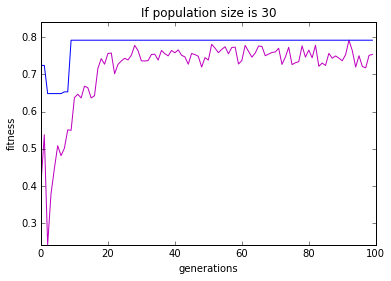

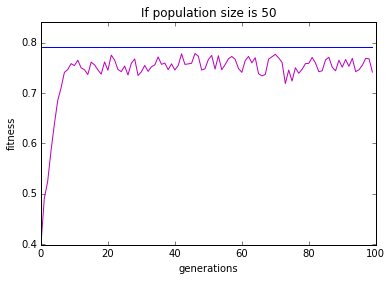

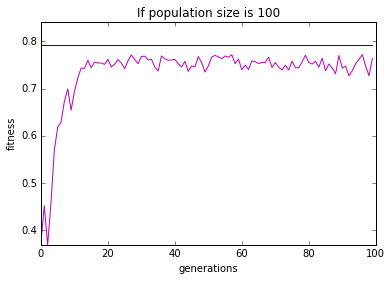

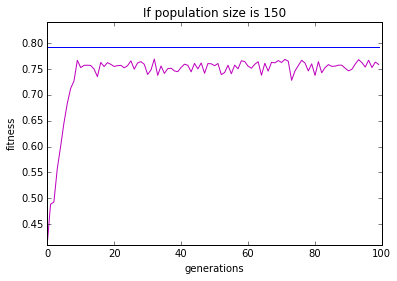

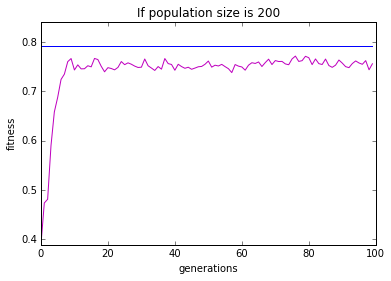

In [42]:
#Putting functions together to evolve my Organisms and their offspring, which are subjected to mutations and genomic imprinting

R=[10,30,50,100,150,200]         #experiment 2: increase population size
for popSize in R:
    N=5     
    P=makePopulation(N,popSize) 
    generations=100

    meanW=list() 
    maxW=list()

    for generation in range(generations):     
        W=list()                            #will contain the fitnesses of all of our Organisms  

        for j in range(len(P)):             
            W.append(P[j].fitness)

    #next generation of organisms are offspring of the previous generation's fittest individuals (subjected to imprinting and mutations)
        nextGeneration=list()
        while len(nextGeneration)<len(P):
            who=random.randint(0,popSize-1)
            who2=random.randint(0,popSize-1)
            if W[who]>W[who2]:
                O=Organism(P[who],N,mutRate)
            else:
                O=Organism(P[who2],N,mutRate)
            O.computeMethylation()
            nextGeneration.append(O)

        P=list(nextGeneration)
        meanW.append(mean(W))
        highestFitness=max(W)
        maxW.append(highestFitness)

    figure()
    title("If population size is {0}".format(popSize))
    plot(meanW,'m')
    plot(maxW,'b')
    xlabel("generations")
    ylabel("fitness")
    ylim(min(meanW),highestFitness+0.05)

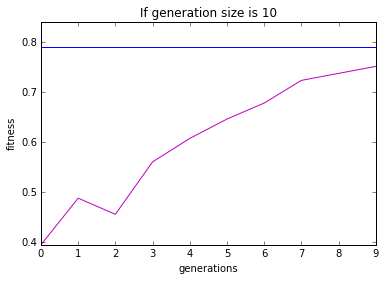

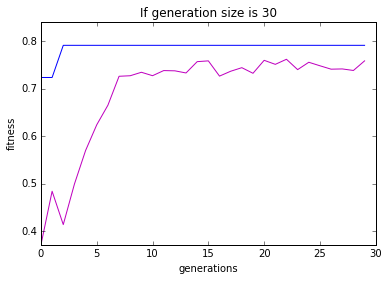

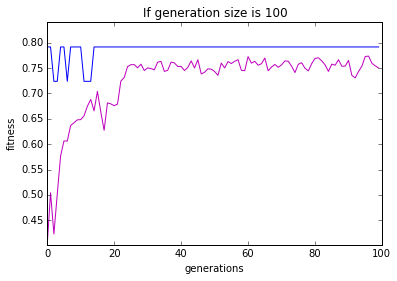

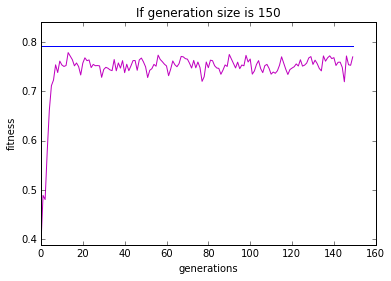

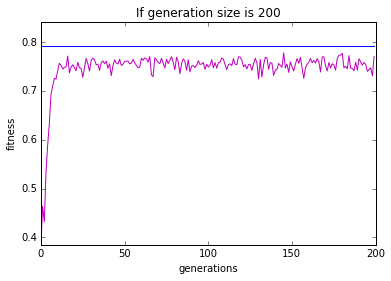

In [57]:
#Putting functions together to evolve my Organisms and their offspring, which are subjected to mutations and genomic imprinting

gens=[10,30,100,150,200]              #experiment 3: increase generation size
for generations in gens:
    N=5 
    popSize=100
    P=makePopulation(N,popSize) 
    
    meanW=list() 
    maxW=list()

    for generation in range(generations):     
        W=list()                            #will contain the fitnesses of all of our Organisms  

        for j in range(len(P)):             
            W.append(P[j].fitness)

    #next generation of organisms are offspring of the previous generation's fittest individuals (subjected to imprinting and mutations)
        nextGeneration=list()
        while len(nextGeneration)<len(P):
            who=random.randint(0,popSize-1)
            who2=random.randint(0,popSize-1)
            if W[who]>W[who2]:
                O=Organism(P[who],N,mutRate)
            else:
                O=Organism(P[who2],N,mutRate)
            O.computeMethylation()
            nextGeneration.append(O)

        P=list(nextGeneration)
        meanW.append(mean(W))
        highestFitness=max(W)
        maxW.append(highestFitness)

    figure()
    title("If generation size is {0}".format(generations))
    plot(meanW,'m')
    plot(maxW,'b')
    xlabel("generations")
    ylabel("fitness")
    ylim(min(meanW),highestFitness+0.05)

(0.7, 0.9)

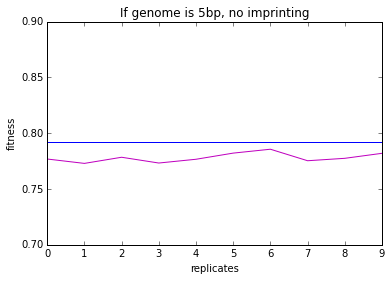

In [62]:
random.seed(0)
maxWs=list()
meanWs=list()
for x in range(10):
    N=5
    popSize=100
    P=makePopulation(N,popSize) 
    generations=100

    meanW=list() 
    maxW=list()

    for generation in range(generations):     
        W=list()                            #will contain the fitnesses of all of our Organisms  

        for j in range(len(P)):             
            W.append(P[j].fitness)

    #next generation of organisms are offspring of the previous generation's fittest individuals (subjected to imprinting and mutations)
        nextGeneration=list()
        while len(nextGeneration)<len(P):
            who=random.randint(0,popSize-1)
            who2=random.randint(0,popSize-1)
            if W[who]>W[who2]:
                O=Organism(P[who],N,mutRate)
            else:
                O=Organism(P[who2],N,mutRate)
            #O.computeMethylation()
            nextGeneration.append(O)

        P=list(nextGeneration)
        meanW.append(mean(W))
        highestFitness=max(W)
        maxW.append(highestFitness)
    maxWs.append(max(maxW))#maxWs.append(sum(maxW)/len(maxW))
    meanWs.append(max(meanW))#meanWs.append(sum(meanW)/len(meanWs))

figure()
title("If genome is {0}bp, no imprinting".format(N))
plot(maxWs,'b')
plot(meanWs,'m')
xlabel("replicates")
ylabel("fitness")
ylim(0.7,0.9)

(0.7, 0.9)

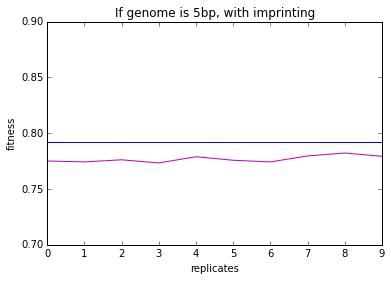

In [63]:
random.seed(0)
maxWs=list()
meanWs=list()
for x in range(10):
    N=5
    popSize=100
    P=makePopulation(N,popSize) 
    generations=100

    meanW=list() 
    maxW=list()

    for generation in range(generations):     
        W=list()                            #will contain the fitnesses of all of our Organisms  

        for j in range(len(P)):             
            W.append(P[j].fitness)

    #next generation of organisms are offspring of the previous generation's fittest individuals (subjected to imprinting and mutations)
        nextGeneration=list()
        while len(nextGeneration)<len(P):
            who=random.randint(0,popSize-1)
            who2=random.randint(0,popSize-1)
            if W[who]>W[who2]:
                O=Organism(P[who],N,mutRate)
            else:
                O=Organism(P[who2],N,mutRate)
            O.computeMethylation()
            nextGeneration.append(O)

        P=list(nextGeneration)
        meanW.append(mean(W))
        highestFitness=max(W)
        maxW.append(highestFitness)
    maxWs.append(max(maxW))#maxWs.append(sum(maxW)/len(maxW))
    meanWs.append(max(meanW))#meanWs.append(sum(meanW)/len(meanWs))

figure()
title("If genome is {0}bp, with imprinting".format(N))
plot(maxWs,'b')
plot(meanWs,'m')
xlabel("replicates")
ylabel("fitness")
ylim(0.7,0.9)
#plt.subplots(1,2)